# Overview

This notebook presents an LSTM recurrent neural network demo using TensorFlow - Keras. 


References:
* Much of this work is inspired from [amirrezaeian - Github](https://github.com/amirrezaeian/Individual-household-electric-power-consumption-Data-Set-/blob/master/data_e_power.ipynb)
* https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

 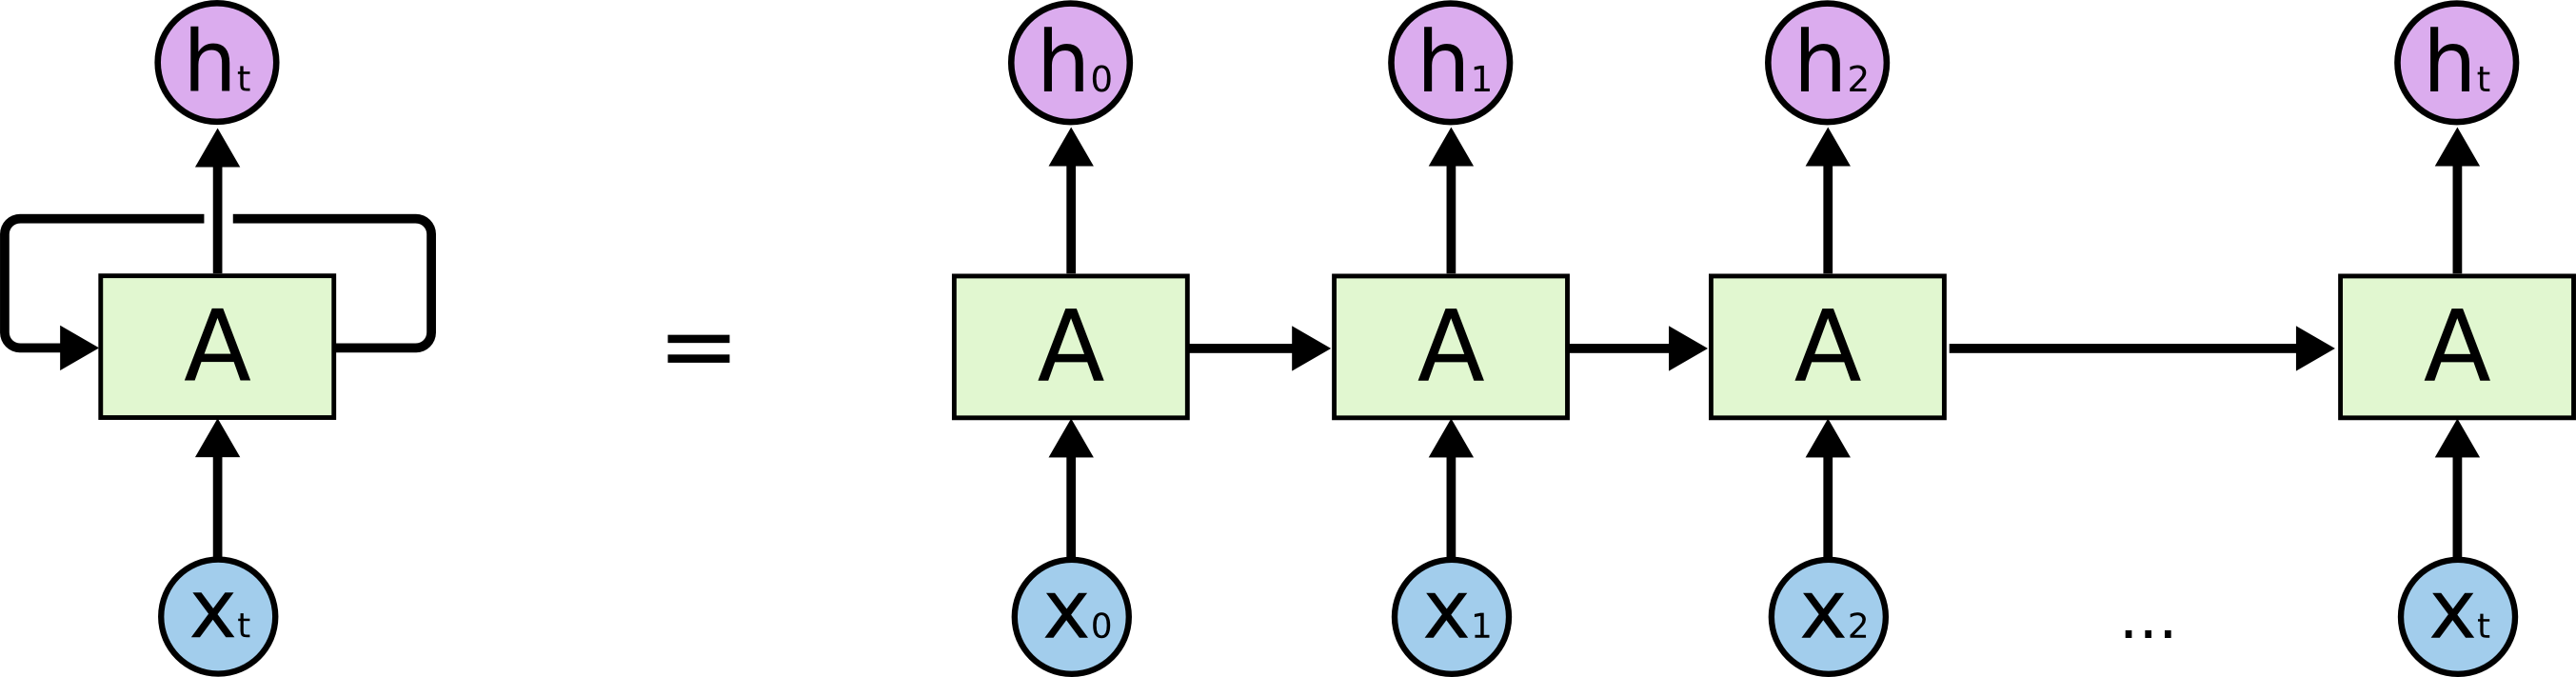

In [72]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sagemaker
import boto3
import datetime
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

# Data

http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

This data represents 2075259 measurements gathered each minute in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).

**Data Details**
1. date: Date in format dd/mm/yyyy
2. time: time in format hh:mm:ss
3. global_active_power: household global minute-averaged active power (in kilowatt)
4. global_reactive_power: household global minute-averaged reactive power (in kilowatt)
5. voltage: minute-averaged voltage (in volt)
6. global_intensity: household global minute-averaged current intensity (in ampere)
7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

**Notes:**
1. (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.
2. The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

## Import Data

In [ ]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip

In [ ]:
!unzip household_power_consumption.zip

In [ ]:
df = pd.read_csv('household_power_consumption.txt', sep=';',low_memory=False, parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, na_values=['nan','?'], index_col='dt')

In [ ]:
print(df.shape)
df.head()

## Data Cleaning and Prep

### Feature Engineering

In [ ]:
# Feature Engineering
# add a column for for the remainder of sub metering
values = df.values.astype('float32')
df['Sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])

In [ ]:
df.head()

### Missing Values

In [ ]:
# check for missing values
df.isnull().sum()

In [ ]:
# Fill Missing Values with the Mean of the Column

for j in range(0,8):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())


In [ ]:
# check for missing values
df.isnull().sum()

### Resample and Save

In [ ]:
## resampling of data over hour, this makes the dataset much easier to analyze and train on
df_resample = df.resample('h').mean() 
df_resample.shape

In [ ]:
# save updated dataset
df_resample.to_csv('household_power_consumption_clean.csv')

In [3]:
# optional - load dataset
df = pd.read_csv('household_power_consumption_clean.csv', infer_datetime_format=True, index_col='dt')
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
dt,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,52.992590
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,36.953335
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,38.553890
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,37.692780
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,33.307777


In [4]:
len(df)

34589

### Train | Val | Test Split

The goal for the split is to have the splits continous and the val and test sets should be the most recent data.  We can't do a random split that is typically done for classification problems since it is too easy to predict the missing data in a time series.  For further reading see this great [fastai post](https://www.fast.ai/2017/11/13/validation-sets/) 

In [5]:
# sort
df.sort_index(inplace=True)

trainpct = 0.7
trainidx = int(np.round(len(df)*trainpct))
train_df = df.iloc[0:trainidx,:]

valpct = 0.2
validx = int(np.round(len(df)*(trainpct+valpct)))
val_df = df.iloc[trainidx:validx,:]
             
test_df = df.iloc[validx::,:]

### Scaling and Normalization

Any Scaling and Normalization is done from the training dataset only.  This is then applied to the validation and testing datasets.

In [6]:
# scale data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_df.values)

train_scaled = scaler.transform(train_df.values)
val_scaled = scaler.transform(val_df.values)
test_scaled = scaler.transform(test_df.values)

# back to pandas
train_scaled_df = pd.DataFrame(train_scaled,columns=train_df.columns,index=train_df.index)
val_scaled_df = pd.DataFrame(val_scaled,columns=val_df.columns,index=val_df.index)
test_scaled_df = pd.DataFrame(test_scaled,columns=test_df.columns,index=test_df.index)

### Resize for LSTM

For an LSTM the data must be in 3 dimensions - (total_time - lookback) x (lookback) x (variables)

In [7]:
## create a list of all parameters for seq_length timestamps to be used for prediction models ##
def gen_sequence(id_df, seq_length, seq_cols, step=1):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length, step), range(seq_length, num_elements, step)):
        yield data_array[start:stop, :]

def build_datasets_rnn(df,seq_length,in_params,out_params):
    """ Function to reformat the pandas dataframe so it can be used in the RNN.  The output will be a numpy array
    with the shape of len(df)-seq_length x seq_length x len(in_params).  The out_array is the prediction variable.  
    It is one time step ahead.  For an example, if the seq_lenght was 10 then the input array would represent t-1 to t-10
    and the out array would be at time t"""
    
    # build X
    seq_array = np.empty([len(df) - seq_length, seq_length, len(in_params)], dtype=np.float32)
    arr = list(gen_sequence(df,seq_length,in_params))
    for j in range(len(df)-seq_length):
        seq_array[j,:,:] = arr[j]
        
    # build Y
    out_array = df[out_params].values[seq_length::]
    
    return seq_array,out_array

In [8]:
lookback = 48
X_train,Y_train = build_datasets_rnn(train_scaled_df,lookback,['Global_reactive_power', 'Voltage','Global_intensity', 'Sub_metering_1', 'Sub_metering_2','Sub_metering_3', 'Sub_metering_4'],['Global_active_power'])
X_val,Y_val = build_datasets_rnn(val_scaled_df,lookback,['Global_reactive_power', 'Voltage','Global_intensity', 'Sub_metering_1', 'Sub_metering_2','Sub_metering_3', 'Sub_metering_4'],['Global_active_power'])
X_test,Y_test = build_datasets_rnn(test_scaled_df,lookback,['Global_reactive_power', 'Voltage','Global_intensity', 'Sub_metering_1', 'Sub_metering_2','Sub_metering_3', 'Sub_metering_4'],['Global_active_power'])

In [9]:
# save data 
np.savez_compressed('training.npz', x=X_train, y=Y_train)
np.savez_compressed('testing.npz', x=X_test, y=Y_test)
np.savez_compressed('validation.npz', x=X_val, y=Y_val)

# LSTM Model

Define the model architecture

Goal is to predict global active power using the other variables with a look back of 48 hours

In [74]:
neurons = 64
batch_size = 512
epochs = 15

In [73]:
model = tf.keras.Sequential()

model.add(layers.LSTM(
    X_train.shape[1],
    input_shape=(X_train.shape[1],X_train.shape[2]),
    return_sequences=True,
    #dropout=0.2,
    #recurrent_dropout=0.2
    ))

model.add(layers.LSTM(
    neurons,
    return_sequences=False,
    #dropout=0.2,
    #recurrent_dropout=0.2
    ))

model.add(layers.Dense(neurons,activation="relu"))

model.add(layers.Dense(Y_train.shape[1]))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 48, 48)            10752     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                28928     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 43,905
Trainable params: 43,905
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
callback_list = []
cp = callbacks.ModelCheckpoint(filepath="lstm_demo.{epoch:02d}.hdf5",verbose=1)
callback_list.append(cp)

# Training

In [75]:
%time
lstm_history = model.fit(X_train,Y_train, epochs=epochs, batch_size=batch_size, 
                                                validation_data=(X_val, Y_val),
                                                verbose=1, callbacks=callback_list)

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 14.1 µs
Train on 24164 samples, validate on 6870 samples
Epoch 1/15
24064/24164 [============================>.] - ETA: 0s - loss: 0.0191 - mean_absolute_error: 0.1080
Epoch 00001: saving model to lstm_demo.01.hdf5
24164/24164 [==============================] - 13s 527us/sample - loss: 0.0191 - mean_absolute_error: 0.1080 - val_loss: 0.0152 - val_mean_absolute_error: 0.0965
Epoch 2/15
24064/24164 [============================>.] - ETA: 0s - loss: 0.0158 - mean_absolute_error: 0.0967
Epoch 00002: saving model to lstm_demo.02.hdf5
24164/24164 [==============================] - 7s 291us/sample - loss: 0.0158 - mean_absolute_error: 0.0967 - val_loss: 0.0123 - val_mean_absolute_error: 0.0850
Epoch 3/15
24064/24164 [============================>.] - ETA: 0s - loss: 0.0116 - mean_absolute_error: 0.0788
Epoch 00003: saving model to lstm_demo.03.hdf5
24164/24164 [==============================] - 7s 290us/sample - loss: 0.0116 - mean_a

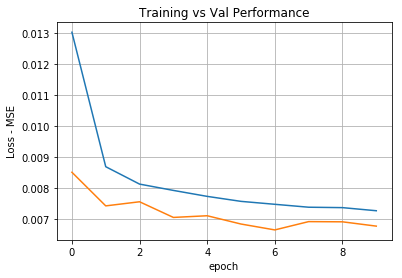

In [62]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.ylabel('Loss - MSE')
plt.xlabel('epoch')
plt.title('Training vs Val Performance')
plt.grid()

In [63]:
# Save entire model to a HDF5 file
model.save('my_model')

In [43]:
# save a json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 

Saved model to disk


In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

In [23]:
# Recreate the exact same model, including weights and optimizer.
model = tf.keras.models.load_model('my_model')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Evaluation

In [64]:
y_hat = model.predict(X_test, batch_size=batch_size)

In [65]:
# mse
from sklearn.metrics import mean_squared_error
mse_test = mean_squared_error(Y_test,y_hat)

In [66]:
mse_test

0.005006416328644951

In [67]:
# check
model.evaluate(X_test, Y_test, batch_size=batch_size)

3411/3411 [==============================] - 1s 255us/sample - loss: 0.0050 - mean_absolute_error: 0.0472


[0.005006416381465894, 0.047179796]

In [68]:
from datetime import datetime
tt = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in test_scaled_df.index.values]

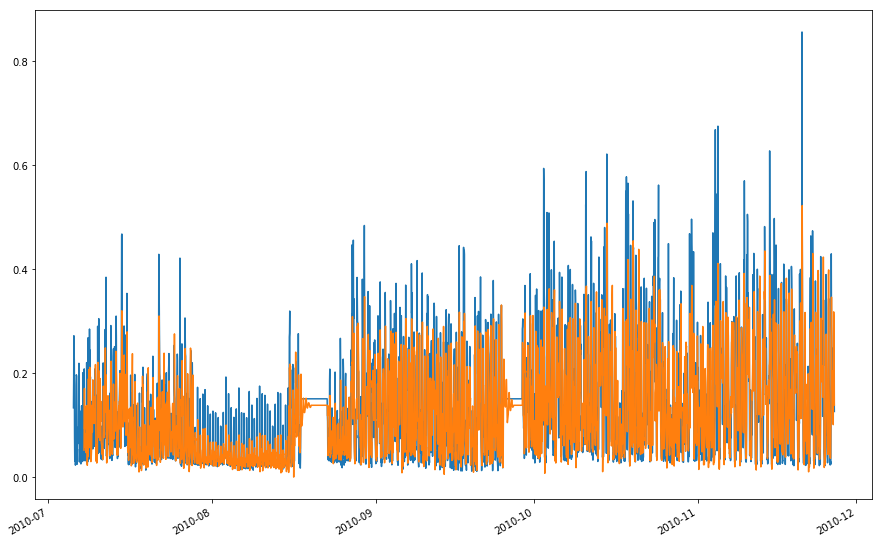

In [69]:
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(tt, y)
plt.plot(tt[48::],y_hat)
fig.autofmt_xdate()
#ax.set_xlim([datetime.date(2014, 1, 26), datetime.date(2014, 2, 1)])
#ax.set_ylim([0, 5])

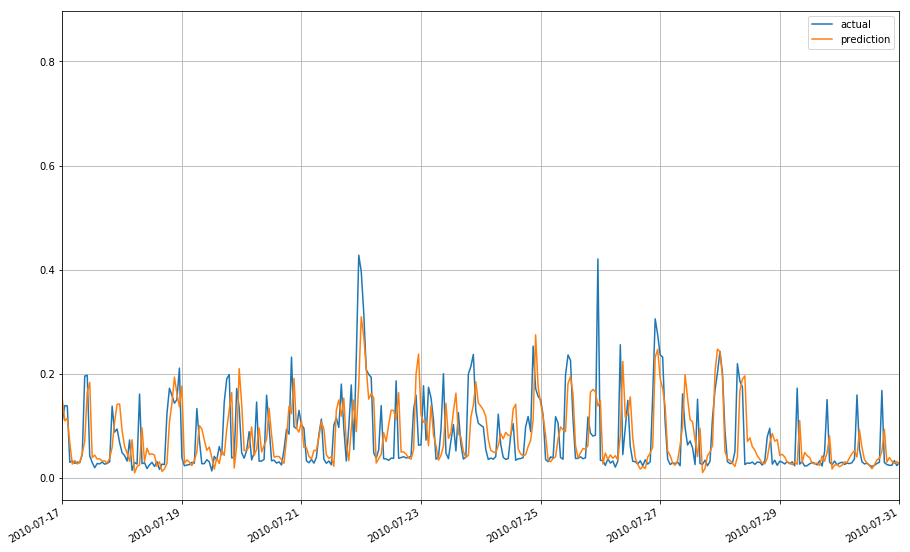

In [70]:
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(tt, y)
plt.plot(tt[48::],y_hat)
fig.autofmt_xdate()
ax.set_xlim([datetime(2010, 7, 17), datetime(2010, 7, 31)])
plt.legend(['actual','prediction'])
plt.grid()
#ax.set_ylim([0, 5])

# Deployment

In [44]:
from tensorflow.python.saved_model import builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants

In [ ]:
model_version = '1'
export_dir = 'export/Servo/' + model_version

# Build the Protocol Buffer SavedModel at 'export_dir'
builder = builder.save(export_dir)

# Create prediction signature to be used by TensorFlow Serving Predict API
signature = predict_signature_def(
    inputs={"inputs": model.input}, outputs={"score": model.output})

from keras import backend as K

with K.get_session() as sess:
    # Save the meta graph and variables
    builder.add_meta_graph_and_variables(
        sess=sess, tags=[tag_constants.SERVING], signature_def_map={"serving_default": signature})
    builder.save()



In [ ]:
builder

In [ ]:
import tarfile
with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add('export', recursive=True)

import sagemaker

sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')



In [47]:
model.input

<tf.Tensor 'lstm_input_1:0' shape=(?, 48, 7) dtype=float32>